# CMEMS OMI BLACKSEA OXYGEN

This notebook aims to collect the Argo data and issue the netcdf and figure files required for an update of the CMEMS Ocean Monitoring Index (OMI) dedicated to the Black Sea oxygenation status (open basin). 

More info available at [The OMI webpage](https://marine.copernicus.eu/access-data/ocean-monitoring-indicators/black-sea-oxygen-trend-observations-reprocessing), [The reference publication](https://bg.copernicus.org/articles/13/1287/2016/).

Executions steps includes: 
* Data acquisition
* Data processing
* File generation
* Figure generation

Then some files should be updated manually to complement the documentation.

*Codes by A. Capet - Jun 2022 - acapet - AT- uliege.be*

In [263]:
import pandas as pd
import xarray as xr
import numpy as np

#import cmocean as cm 
from matplotlib import pyplot as plt
import cartopy.crs as ccrs

#import matplotlib as mpl
import matplotlib.dates as mdates
import calendar
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import gsw 

import wget
import os
import datetime as dt
import netCDF4


#### Parameters

In [203]:
## Criterion & Thresholds

# Minimum number of ship profiles to take into consideration the DIVA detrending value
minNprofShip = 10

# Do you want a detailed description of what is going on ? 
verbose=False

# Last year to consider Argo data (included) .. Supposedly, updating the OMI only requires changing that number.
lastyear = 2021 


In [5]:
# List of diagnostics
vlist = ['Z20','R20','VOC']

# Dictionary for variables attributes (plotting, netcdf, etc .. )
vdic  = {'Z20':{'ylim'          : (250,0),
                'ylimM'         : (200,50),
                'units'         : 'm',
                'long_name'     : "Oxygen penetration depth",
                'name'          : 'oxygen_penetration_depth', 
                'standard_name' : 'ocean_layer_thickness_defined_by_mole_concentration_of_dissolved_molecular_oxygen_in_sea_water_above_threshold',
                'FillValue'     : -9999.0, 
                'comment'       : 'Depth over which [O2] > 20 mmol/m3', 
                'minsc'         : 250, 
                'maxsc'         : 0,
                'ncname'        : 'olto2'
               },
         
         'R20':{'ylim'          : (16.5,14.5),
                'ylimM'         : (16.5,15.0),
                'units'         : 'kg m-3',#units         = 'kg/m3',
                'long_name'     : "Oxygen penetration density",
                'name'          : 'oxygen_penetration_density',
                'standard_name' : 'sea_water_sigma_theta_defined_by_mole_concentration_of_dissolved_molecular_oxygen_in_sea_water_above_threshold',
                'FillValue'     : -9999.0,
                'comment'       : 'Potential density anomaly at the oxygen penetration depth (above which [O2]>20µM)',
                'minsc'         : 17.5, 
                'maxsc'         : 14.5,
                'ncname'        :'odo2'
               },
         
         'VOC':{'ylim'          : (0,42)  ,
                'ylimM'         : (10,35) ,
                'units'         : 'mol m-2',
                'long_name'     : "Vertically integrated oxygen content",
                'name'          : 'oxygen_inventory',
                'standard_name' : 'ocean_mole_content_of_dissolved_molecular_oxygen',
                'FillValue'     : -9999.0,
                'comment'       : 'Oxygen inventory is integrated from surface to the oxygen penetration depth (above which [O2]>20µM)',
                'minsc'         : 0, 
                'maxsc'         : 45,
                'ncname'        : 'into2'
               }
        }
         


In [6]:
# Path  to save the OMI netcdf file
path = './Output_' + dt.datetime.now().strftime("%Y%m%d")+'/' # -%H%M  # Add this to date format for distinct outputs
os.mkdir(path)
  
# -- OMI file name
area            = 'blksea'             
short_omi_name  = 'omi_health_oxygen'   
prod_time       = 'P'+ dt.datetime.now().strftime( "%Y%m%d")

## 1. Data Acquisition

### 1.1 Historical data 

Trends from [Capet et al. 2014](https://link.springer.com/article/10.1007/s10236-013-0683-4) are stored in .dat files, that are part of this repo. These trends aren't re-evaluated upon OMI update. 

In [7]:
# Loading the full list of in-situ data used in the DIVA detrending approach. 
# In particular, we need the mean value to interpret the relative trends stored in the .dat files

hdatadir='./HistData/'

# Build the data frame from the .dat files
plist=[]
for v in ('R20','Z20','VOC'):
    p1 = pd.read_csv(hdatadir+v+'.dat', names=["lat","lon","value","month","year","weight"],
                     delimiter='   ', engine='python', dtype={"lat":np.float64,
                                                              "lon":np.float64,
                                                              "Value":np.float64,
                                                              "Month":np.int32,
                                                              "Year":np.int32,
                                                              "Weight":np.float64})
    p1['var']=v
    plist.append(p1)

# Merge all three diagnostics in a single dataframe
phist=pd.concat(plist)    

# Issue average values
globalmeans = phist.groupby('var').mean()

# Count number of profiles per year
pnrpofs = phist[['var','year','value']].groupby(['var','year']).count().reset_index().rename(columns={'value':'nprof'})

In [8]:
# Loading the trends, and adding the mean value
plist=[]
for v in ('R20','Z20','VOC'):
    p1 = pd.read_csv(hdatadir+v+'_trends2_00.dat', names=["index","trends"], delim_whitespace=True)
    p1['var']=v
    p1['trends']=p1['trends']+globalmeans['value'][v]
    p1['year']=[ r for r in range(1923,2013+1)]
    # We only use Z20 for profile counts. It only differs in rare occasions by one or two for 20.
    p1=p1.merge(pnrpofs[pnrpofs["var"]==v],how='left', on=['year','var'])
    plist.append(p1)
    
trendshist=pd.concat(plist)
trendshist=trendshist[['var','year','trends','nprof']]
trendshist['nprof'][np.isnan(trendshist['nprof'])]=0.0

trendshist['trends'][trendshist['nprof']<minNprofShip]=np.nan
trendshist=trendshist[(trendshist.year>=1955 ) ] #&(trendshist.year<1975 )

In [9]:
# This verifies that the number of eligible profiles is very similar from one variable to another
# (which is not given a priori).
dfnprofs= trendshist.pivot_table(index=['year'], columns='var',values='nprof', dropna=False).reset_index()
dfnprof = dfnprofs[['year','Z20']].rename(columns={"Z20":"nprof"})

In [10]:
# Cast the dataframe
ShipAnnual = trendshist.pivot_table(index=['year'], columns='var',values='trends', dropna=False).reset_index()

# Add Nprofs
ShipAnnual = ShipAnnual.merge(dfnprof, how='left', on=['year'])

# Unit conversion for VOC
ShipAnnual['VOC']=ShipAnnual['VOC']/1000

In [11]:
if verbose: display(ShipAnnual)

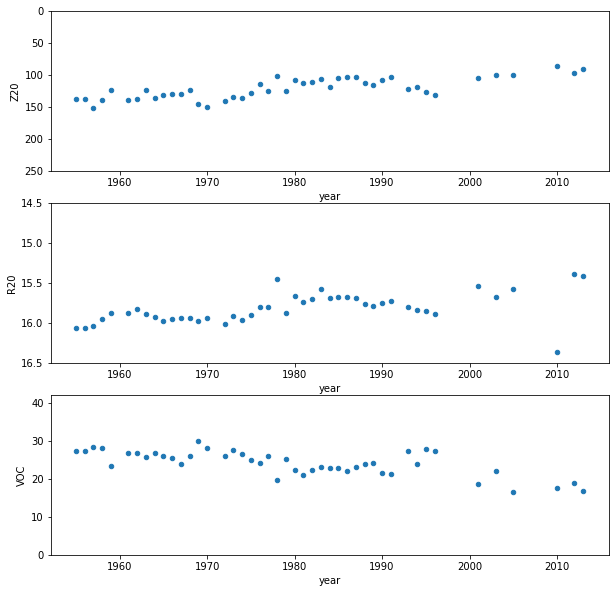

In [12]:
# Quick Check
fig,axs = plt.subplots(3,1, figsize=(10,10))

for v,a in zip(vlist,axs):
    ShipAnnual.plot.scatter(x='year',y=v, ax=a)
    a.set_ylim(vdic[v]['ylim'])

### 1.2 Argo Data. 

* Using SPROF approach from Ifremer's repository.
* QF filtering option.

In [13]:
# Obtain and read the listing
iftp= 'ftp://ftp.ifremer.fr/ifremer/argo/'

print(iftp+'argo_synthetic-profile_index.txt')
    if os.path.exists('argo_synthetic-profile_index.txt'):
        os.remove('argo_synthetic-profile_index.txt') 
flist=wget.download(iftp+'argo_synthetic-profile_index.txt')

# LOADING THE FULL LIST
dfall = pd.read_csv(flist, header=8).sort_index(1)

ftp://ftp.ifremer.fr/ifremer/argo/argo_synthetic-profile_index.txt
100% [........................................................................] 36827350 / 36827350

/tmp/ipykernel_15536/1840853577.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  dfall = pd.read_csv(flist, header=8).sort_index(1)


In [14]:
# Some handy functions

def julian_to_human(group):
    # convert time 
    gregorian_time = dt.datetime(1950, 1, 1) + dt.timedelta(days=np.min(group['time']).astype('float'))
    group['human_time'] = gregorian_time
    return(group)

def start_axes(title, extent, fig=None, sp=None, titleloc='title'):
    if fig is None:
        fig = plt.figure(figsize=(13, 5))
        
    if sp is None:
        ax = fig.add_axes([0.03, 0.03, 0.90, 0.94],projection=ccrs.PlateCarree())
    else:
        ax = fig.add_subplot(sp,projection=ccrs.PlateCarree())
            
    ax.set_extent(extent)
    ax.gridlines(alpha=.3)
    ax.coastlines(resolution='10m')
    #ax.set_xlim(-6, 36.5), ax.set_ylim(30, 46)
    #ax.set_aspect("equal")
    if titleloc=='title':
        ax.set_title(title)
    else:
        ax.text(x=titleloc[0],y=titleloc[1],s=title)
        
    gl=ax.gridlines(draw_labels=True)#
    gl.top_labels = False
    gl.right_labels = False
    return ax

def update_axes(ax, mappable=None, unit='', below=False):
    ax.grid()
    if mappable:  ### FIX in source : m-> mappable
        cbar=plt.colorbar(mappable, orientation="vertical")
        cbar.ax.set_xlabel(unit)
    return(cbar)

def subsetfordomain(dfall,d):
        # SUBSETTING SPATIALLY
    lonmin = d['lonmin']
    lonmax = d['lonmax']
    latmin = d['latmin']
    latmax = d['latmax']
    
    df=dfall.loc[(dfall['latitude'] >d['latmin']) & 
                 (dfall['latitude'] <d['latmax']) &
                 (dfall['longitude']>d['lonmin']) & 
                 (dfall['longitude']<d['lonmax'])].copy()
    
    
    # ADDING TIME IN CONVENIENT FORMAT
    dftime=[]
    for i,t in enumerate(df.date):
        dftime.append((dt.datetime.strptime(str(int(t)), "%Y%m%d%H%M%S")- dt.datetime(1950, 1, 1,0,0,0)).days)

    df['time']=dftime

    df=df.groupby('time').apply(julian_to_human)
    
    # Adding WMO and DAC
    df['wmo']= [ int(s.split('/')[1]) for s in df['file']]
    df['dac']= [ s.split('/')[0] for s in df['file']]
    
    
    # SUBSETTING TEMPORALLY
    df=df.loc[(df['human_time']>datmin)&(df['human_time']<datmax) ]
    return(df)

In [15]:
d1 = { 'domain':'BLKSEA', 'latmin':40.5, 'latmax':47, 'lonmin':27.5, 'lonmax':42}

datmin = dt.datetime(2010,1,1)
datmax = dt.datetime(lastyear,12,31)


A figure of considered float's position and temporal coverage

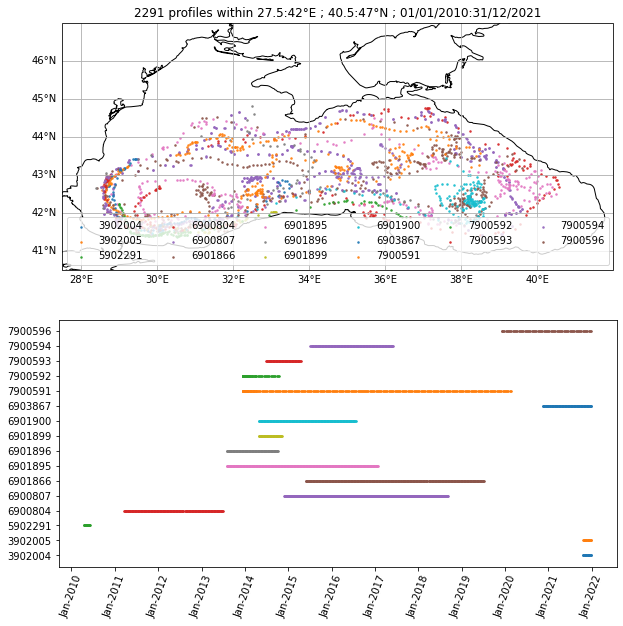

In [16]:
for d in [d1]: 
    ddir='./ArgoData/'
    # Create directory
    if not os.path.exists(ddir):
        os.makedirs(ddir)
    
    df=subsetfordomain(dfall,d)
    lonmin = d['lonmin']
    lonmax = d['lonmax']
    latmin = d['latmin']
    latmax = d['latmax']
    
    # Some plots about profiles meta data. 
    expfact=0
    lonrange=expfact*(lonmax-lonmin)
    latrange=expfact*(latmax-latmin)
    extent = [lonmin-lonrange,lonmax+lonrange,latmin-latrange,latmax+latrange]

    fig = plt.figure(figsize=(10,10))
    
    a=start_axes(str(df.date.count()) + " profiles within " + 
             str(lonmin)+':'+str(lonmax)+'°E ; '+str(latmin)+':'+str(latmax)+'°N ; '+
            datmin.strftime('%d/%m/%Y')+':'+datmax.strftime('%d/%m/%Y'), extent=extent, fig=fig, sp=211)

    a2=fig.add_subplot(212)
    
    from matplotlib.dates import DateFormatter
    # Define the date format
    date_form = DateFormatter("%b-%Y")
    a2.xaxis.set_major_formatter(date_form)

    # Ensure a major tick 
    a2.xaxis.set_major_locator(mdates.YearLocator())

    for i,w in enumerate(df.wmo.unique()):
        ldf=df[df.wmo==w]
        
        s=10 #25 if 'CHLA' in ldf.parameters.unique()[0] else 10
        ma='.' #'x' if 'CHLA' in ldf.parameters.unique()[0] else '.'
        m=a.scatter(x=ldf.longitude, y=ldf.latitude,label=w,s=s,alpha=.8,transform=ccrs.PlateCarree(), marker=ma)##

        a2.scatter(x=ldf.human_time, y=(i+1)*np.ones(len(ldf.human_time)), s=s , marker=ma)
        
    a.legend( loc="lower center", 
                bbox_transform=fig.transFigure, ncol=6)

        
    a2.set_yticks(np.linspace(1,len(df.wmo.unique()),len(df.wmo.unique())))    
    a2.set_yticklabels(df.wmo.unique())    

    plt.xticks(rotation=70)
            
    
#    for l,L,s in zip(df.latitude, df.longitude, [ d.strftime('%d/%m') for d in df.human_time]):
#        plt.text(x=L,y=l,s=s,transform=ccrs.PlateCarree())
    
    #fig.tight_layout()

    plt.savefig(ddir+'Argo_Location',facecolor='white')

Now, acquiring the data from the individual floats, and reading them toward panda dataframes

In [17]:
# Thanks F. Ricour ! 


def download_float(dac, wmo, proftype, ddir='./ArgoData/'):
    """
    dac : data center, e.g. 'coriolis'
    wmo : world id of the float (unique), e.g. 6901866
    """
    
    # check if float folder exists
    if(os.path.isdir(ddir) == False):
        os.mkdir(os.path.join(os.getcwd(),ddir))
    # check if file already exists in that folder
    if(os.path.isfile(ddir+str(wmo)+'_'+proftype+'.nc') == False):
        print("File does not exist")
        print("File is being downloaded")
        print("...")
        base_url = 'ftp://ftp.ifremer.fr/ifremer/argo/dac/'
        full_url = base_url+dac+'/'+str(wmo)+'/'
        link = full_url+str(wmo)+'_'+proftype+'.nc'
        wget.download(link, out = ddir)
        print("Done !")
    else:
        if verbose: print("File already exists, moving on.")
            
def bytes_to_int(x):
    try:
        x = int(x)
    except:
        x = 10
    return(x)   

def read_data(wmo, proftype, varlist, ddir=os.getcwd()+'/ArgoData/'):
    
    # ADJUSTED variables will automatically be used instead of variables if at least ONE ADUJSTED QF is <3
    #   -> the rationale being that this means the ADJUSTING procedure has been done.
    # Obviously, corresponding QF are then considered. 
    #
    # Those are the list of QF that will be kept
    keepmeQF=[1,2,3,5,8]
    
    
    ncfile = str(wmo)+'_'+proftype+'.nc'
    if verbose: print(ncfile)
    # see also the doc for SYNTHETIC BGC-ARGO files: https://archimer.ifremer.fr/doc/00445/55637/75359.pdf
    nc = netCDF4.Dataset(ddir+ncfile, mode='r') # add a get url download the file in a folder then read it
    # get coordinates variables
    lat = nc.variables['LATITUDE'][:].data
    lon = nc.variables['LONGITUDE'][:].data
    time = nc.variables['JULD'][:].data
    depth = nc.variables['PRES'][:].data
    depth_qc = np.array([ bytes_to_int(x) for x in np.concatenate(nc.variables['PRES_QC'][:].data)])
    
    # put data into a Dataframe
    data = pd.DataFrame({'depth':np.concatenate(depth),
                         'depth_qc':depth_qc})
    
    #other parameters
    for v in varlist:
        if verbose: print(v+' is read from  ' + ncfile)
        try:
            vdata = np.concatenate(nc.variables[v][:].data)
            vqc   = np.array([ bytes_to_int(x) for x in np.concatenate(nc.variables[v+'_QC'][:].data)])

            vdata_A = np.concatenate(nc.variables[v+'_ADJUSTED'][:].data)
            vqc_A   = np.array([ bytes_to_int(x) for x in np.concatenate(nc.variables[v+'_ADJUSTED_QC'][:].data)])

            if(any(vqc_A<3)):
                data[v.lower()] = vdata_A
                data[v.lower()+'_qc'] = vqc_A
                if verbose: print('Adjusted values available for '+v)
            else:
                data[v.lower()] = vdata
                data[v.lower()+'_qc'] = vqc
                if verbose: print('NO Adjusted values available for '+v)
            
        except Exception as e: 
            if verbose: print(e)
            if verbose: print(v+' not found in '+ncfile)
            if verbose: print('passing over..')
            data[v.lower()] = np.nan
            data[v.lower()+'_qc'] = np.nan
            continue
        
    # ADDING SIGMA #
    vdataT = nc.variables['TEMP'][:].data
    vdataS = nc.variables['PSAL'][:].data
    # https://teos-10.github.io/GSW-Python/gsw_flat.html#gsw.SA_from_SP
    # gsw.SA_from_SP(SP, p, lon, lat)
    SA=gsw.SA_from_SP(vdataS, depth, np.tile(lon,(depth.shape[1],1)).T, np.tile(lat,(depth.shape[1],1)).T)
    # https://teos-10.github.io/GSW-Python/gsw_flat.html#gsw.pt_from_t
    pt = gsw.pt0_from_t(SA, vdataT, depth)    
    CT = gsw.CT_from_pt(SA, pt)
    sigma = gsw.sigma0(SA, CT)
    sigma_qc = np.array([ bytes_to_int(x) for x in np.concatenate(nc.variables['PSAL_QC'][:].data)])
    
    data['sigma']=np.concatenate(sigma)
    data['sigma_qc'] = sigma_qc
    
    # close netcdf
    nc.close()
           
    # number of profiles in the file
    n_prof = len(time)
    
    # repeat metadata to fit data length
    points_per_profile = data.shape[0]/n_prof
    time = np.repeat(time, points_per_profile)
    lat = np.repeat(lat, points_per_profile)
    lon = np.repeat(lon, points_per_profile)
    data['time'] = time
    data['lat'] = lat
    data['lon'] = lon

    # add WMO
    data['wmo'] = wmo
    
    # add profile IDs in a similar way
    # ! assuming the hypothesis of constant length per profile is correct (thanks to S profiles?)
    ids = np.array(range(1,n_prof+1))
    data['id'] = np.repeat(ids, points_per_profile)
    
#    Cleaning
    for v in varlist+['depth']:
        data[v.lower()].where((data[v.lower()+'_qc'].isin(keepmeQF)),np.nan, inplace=True)
        
    data = data[~np.isnan(data.depth)]
    data = data[data.depth >= 0]
    
    return(data)    

In [18]:
varlist=['DOXY']

for d in [d1]:
    
    ddir='./ArgoData/'
    if verbose: print(d)
    df=subsetfordomain(dfall,d)
    lonmin = d['lonmin']
    lonmax = d['lonmax']
    latmin = d['latmin']
    latmax = d['latmax']

    floatlist= df.drop_duplicates(['wmo'])[['wmo','dac']]
    if verbose:print('*********')
    if verbose:print(d['domain'])
    if verbose:print('*********')
    
    #Downloading
    if verbose:print("* Downloading *")
    for index, row in floatlist.iterrows():
        if verbose: print(row['dac'], row['wmo'])
        download_float(row['dac'], row['wmo'], 'Sprof',ddir=ddir)
        
    if verbose:print("* Reading *")

    datas=[]

    for index, row in floatlist.iterrows():
        try:
            if verbose: print('Attempting Sprof for ' + str(row.wmo) )
            data= read_data(str(row.wmo), 'Sprof', varlist, ddir=ddir)
        except Exception as e: 
            if verbose:print(e)
            if verbose: print('going for prof for ' + str(row.wmo) )
        datas.append(data)
        if verbose:print('***')

    pdf=pd.concat(datas)
    
    # SUBSETTING ON TIME
    pdf=pdf.groupby('time').apply(julian_to_human)
    pdf=pdf.loc[(pdf['human_time']>datmin) & (pdf['human_time']<datmax) ]
    

In [19]:
if verbose: display(pdf)

## 2. Processing

Here, we prepare functions to derive properties from profiles. 
There are a number of criteria to filter out the profiles that aren't fit for those diagnostics


In [20]:
# First step, only consider valid doxy measurements. 
# The QF selection has already been considred in the loading step.
pdfclean=pdf.drop_duplicates().dropna(subset=['doxy'])

In [21]:
# Criterium for deriving diagnostics out of the Argo profiles

# Part of the profile that is considered: from surface to profbottom
profbottom = 250

# Required number of measurements above profbottom
minNobs = 5

# The profile should contain at least one measurement above mindox
mindox = 20

# The shallowest measurement should be above mindepth
mindepth = 15

# The largest authorized gap between two valid measurements is
maxgap = 40


In [22]:
def AddDiags(oneprof, debug = False):
    global x, r20, z20
    if debug: print('************************')
    if debug: print(oneprof)
    
    ## Profile Selction Criteria ##
    if (all(oneprof['doxy']<20)):
        return None
    elif (len(oneprof)<minNobs):
        return None
    elif (oneprof.depth.min()>mindepth):
        return None
    elif ( np.abs(oneprof.depth.values[1:]-oneprof.depth.values[:-1]).min()>maxgap) :
        return None
    else:
        x=oneprof[['depth','sigma','doxy']].to_xarray().set_coords(["depth","sigma"])
    
    # Diagnostics using xarray
    z20 = x['depth'].where(x['doxy']>20, drop=True).max()
    r20 = x['sigma'].where(x['doxy']>20, drop=True).max()
    # Integration rules  : https://xarray.pydata.org/en/stable/generated/xarray.DataArray.integrate.html
    voc = x.where(x['depth']<z20, drop=True)['doxy'].integrate("depth")/1000.0
    
    outdf = oneprof.iloc[[0]][['human_time','lat','lon']]
    
    outdf['Z20']=z20.data
    outdf['R20']=r20.data
    outdf['VOC']=voc.data
    
    if debug: print(outdf)
    if debug: print('* * * * * * * * * * * * ')
    return (outdf)
    

In [23]:
# We dropped at the end 'lat' and 'lon' but they're available if one wishes to build maps .. 

# To subset when debugging use : e.g. pdfclean[pdfclean.wmo=='7900594'].groupby ...
ArgoDiags= pdfclean.groupby(['wmo','id']).apply(AddDiags).reset_index()[['wmo','human_time']+vlist] 

In [24]:
ArgoDiags=ArgoDiags[ArgoDiags['human_time']>np.datetime64('2012-01-01')]

A quick check on diagnostic values obtained for each individual Argo floats

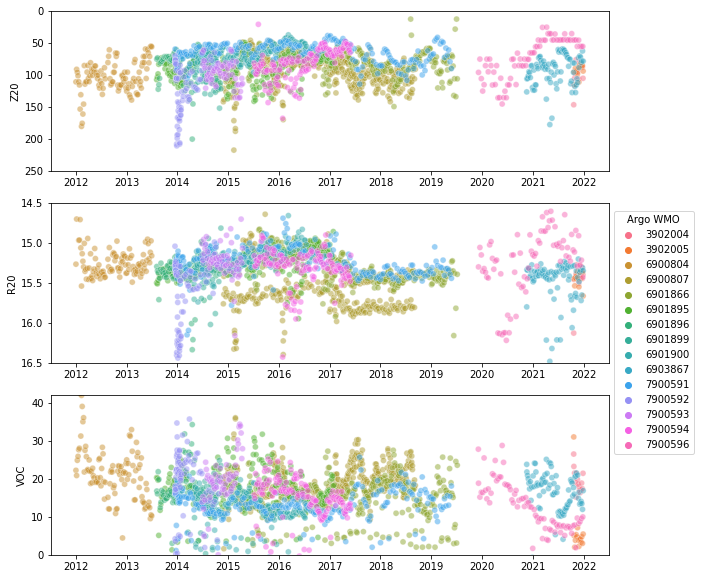

In [25]:
import seaborn as sns

fig,axs = plt.subplots(3,1, figsize=(10,10))

for v,a in zip(vlist,axs):
    g=sns.scatterplot(data=ArgoDiags, x='human_time',y=v, hue='wmo', ax=a, alpha = .5, legend= (False if v!='VOC' else True))
    a.set_ylim(vdic[v]['ylim'])
    a.set_xlabel('')
    
_=g.legend(loc='lower left', bbox_to_anchor=(1., 0.6), ncol=1, title='Argo WMO')


(16.5, 12.0)

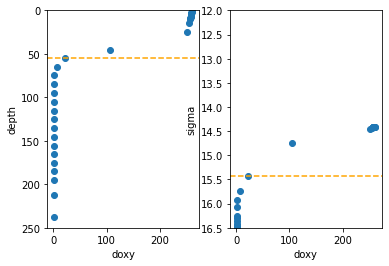

In [26]:
fig,axs=plt.subplots(1,2)

x.plot.scatter(y='depth',x='doxy', ax=axs[0])
axs[0].set_ylim([250,0])
axs[0].axhline(y=z20, color='orange',linestyle='--')

plt

x.plot.scatter(y='sigma',x='doxy', ax=axs[1])
axs[1].axhline(y=r20, color='orange',linestyle='--')
axs[1].set_ylim([16.5,12])

In [27]:
ArgoDiags['year']=[ t.year for t in ArgoDiags.human_time]
ArgoDiags['month']=[ t.month for t in ArgoDiags.human_time]

In [28]:
ArgoAnnual  = ArgoDiags.drop('month', axis=1).groupby('year').agg('mean').reset_index()
ArgoMonthly = ArgoDiags.groupby(['month','year']).agg('mean').reset_index()

In [29]:
if verbose : ArgoAnnual

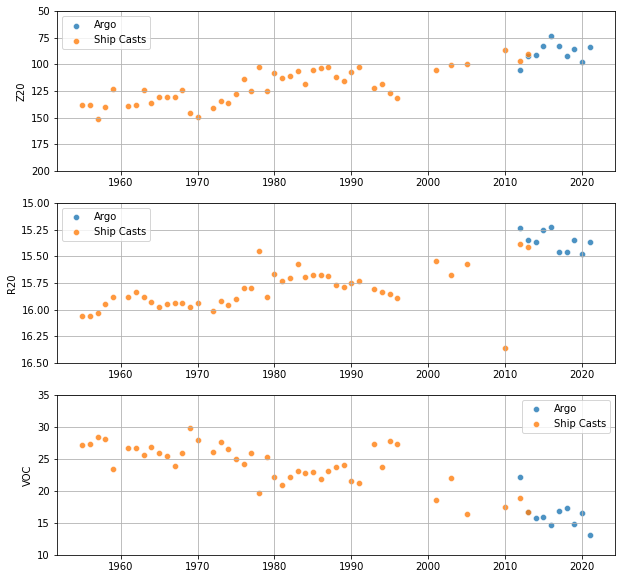

In [30]:
Annual = pd.concat([ArgoAnnual,ShipAnnual[['year','Z20']]])

fig,axs = plt.subplots(3,1, figsize=(10,10))

for v,a in zip(vlist,axs):
    g=sns.scatterplot(data=ArgoAnnual, x='year',y=v, ax=a, alpha = .8, label= 'Argo')
    g2=sns.scatterplot(data=ShipAnnual, x='year',y=v, ax=a, alpha = .8, label= 'Ship Casts')
    a.set_ylim(vdic[v]['ylimM'])
    a.set_xlabel('')
    a.grid()

### 2.2 Add Error Estimates (standard error on the mean)

The error is given as the standard error of the mean, considering standard deviation for each diagnostic estimated on the entire data sets (ie. all Argo profiles, and all DIVA trends respectively)

In [31]:
fullsdArgo= ArgoDiags[vlist].agg('std')
fullsdShip= ShipAnnual[vlist].agg('std')

In [32]:
ArgoAnnualCount  = ArgoDiags.drop('month', axis=1).groupby('year').agg('count').reset_index()[['year','wmo']].rename(columns={'wmo':'nprof'})
ArgoMonthlyCount = ArgoDiags.groupby(['month','year']).agg('count').reset_index()[['year','month','wmo']].rename(columns={'wmo':'nprof'})

In [33]:
for v in vlist:
    ShipAnnual[v+'_err'] = 1.96*fullsdShip[v]/np.sqrt(ShipAnnual['nprof'])
    ArgoAnnual[v+'_err'] = 1.96*fullsdArgo[v]/np.sqrt(ArgoAnnualCount['nprof'])
    ArgoMonthly[v+'_err']= 1.96*fullsdArgo[v]/np.sqrt(ArgoMonthlyCount['nprof'])

## 3. Data File preparation
We prepare, for each variable, a monthly and a annual file. 



### 3.1 Annual Files

In [287]:
xAnnual = pd.concat([ArgoAnnual,ShipAnnual[ArgoAnnual.columns]]).groupby('year').agg('mean').reset_index().to_xarray()
xAnnual = xAnnual.rename_dims({'index':'time'}).rename_vars({'index':'time'})

# Building the time coordinates
midtime= [ np.datetime64(str(y)+'-06-01') for y in xAnnual['year'].data]
begtime= [ np.datetime64(str(y)+'-01-01') for y in xAnnual['year'].data]
endtime= [ np.datetime64(str(y)+'-12-31') for y in xAnnual['year'].data]

xnv= xr.Dataset({'time_bnds':xr.DataArray(np.transpose([begtime,endtime]),dims=["time",'nv']).assign_coords({'time':midtime})})

            # add time_bnds    # remove year
xAnnual = xr.merge([xAnnual,xnv]).drop('year')

for v in vlist:
    xAnnual=xAnnual.rename_vars({v:vdic[v]['name']+'_mean'})
    xAnnual[vdic[v]['name']+'_mean'].attrs['units']=vdic[v]['units']
    xAnnual[vdic[v]['name']+'_mean'].attrs['long_name']=vdic[v]['long_name']+' - annual mean'
    xAnnual[vdic[v]['name']+'_mean'].attrs['standard_name']=vdic[v]['standard_name']
    xAnnual[vdic[v]['name']+'_mean'].attrs['comment']=vdic[v]['comment']
    xAnnual[vdic[v]['name']+'_mean'].attrs['cell_methods']='time: mean'
    
    xAnnual=xAnnual.rename_vars({v+'_err':vdic[v]['name']+'_std'})
    xAnnual[vdic[v]['name']+'_std'].attrs['units']=vdic[v]['units']
    xAnnual[vdic[v]['name']+'_std'].attrs['long_name']=vdic[v]['long_name']+' - annual mean standard error'
    xAnnual[vdic[v]['name']+'_std'].attrs['standard_name']=vdic[v]['standard_name']
    xAnnual[vdic[v]['name']+'_std'].attrs['cell_methods']='time: standard_deviation'

xAnnual['time']=xAnnual['time'].assign_attrs(
    {'long_name':'time',
     'standard_name':'time',
     'axis':'T',
     'bounds':'time_bnds'})


xAnnual.attrs={'institution':'MAST-FOCUS, Liege University',
               'references' :'http://marine.copernicus.eu',
               'Conventions':'CF-1.7',
               'credit'     :'E.U. Copernicus Marine Service Information (CMEMS)',
               'contact'    :'http://marine.copernicus.eu/services-portfolio/contact-us/',
               'source'     :'INSITU_BS_NRT_OBSERVATIONS_013_034',
               'licence'    :'http://marine.copernicus.eu/services-portfolio/service-commitments-and-licence/',
               'area'       :'BLKSEA',
               'comment'    :'Period : 1955-'+str(lastyear)}

In [288]:
if verbose : display(xAnnual)

In [289]:
enc1={vdic[v]['name']+'_mean': {'_FillValue':vdic[v]['FillValue'],'dtype':'float32'} for v in vlist}
enc2={vdic[v]['name']+'_std': {'_FillValue':vdic[v]['FillValue'],'dtype':'float32'} for v in vlist}
enc3={'time':{'dtype':'int32',
              'units':'days since 1950-01-01 00:00:00',
              'calendar':'gregorian'},
      'time_bnds':{'dtype':'int32'}}

In [290]:
xAnnual.to_netcdf(path+area+'_'+short_omi_name+'_trend_annual_'+prod_time+'.nc', 
                 encoding=enc1|enc2|enc3, unlimited_dims='time')

### 3.2 Monthly Files

In [291]:
xMonthly = ArgoMonthly.to_xarray()
xMonthly = xMonthly.rename_dims({'index':'time'}).rename_vars({'index':'time'})


# Building the time coordinates
midtime= [ np.datetime64(str(y)+'-{:02}'.format(m)+'-15') for (m,y) in zip(xMonthly['month'].data,xMonthly['year'].data)]
begtime= [ np.datetime64(str(y)+'-{:02}'.format(m)+'-01') for (m,y) in zip(xMonthly['month'].data,xMonthly['year'].data)]
endtime= [ np.datetime64(str(y)+'-{:02}'.format(m)+'-{:02}'.format(calendar.monthrange(y, m)[1])) for (m,y) in zip(xMonthly['month'].data,xMonthly['year'].data)]

xnv= xr.Dataset({'time_bnds':xr.DataArray(np.transpose([begtime,endtime]),dims=["time",'nv']).assign_coords({'time':midtime})})


            # add time_bnds    # remove year
xMonthly = xr.merge([xMonthly,xnv]).drop(['year','month'])
xMonthly = xMonthly.sortby('time')

for v in vlist:
    xMonthly=xMonthly.rename_vars({v:vdic[v]['name']+'_mean'})
    xMonthly[vdic[v]['name']+'_mean'].attrs['units']=vdic[v]['units']
    xMonthly[vdic[v]['name']+'_mean'].attrs['long_name']=vdic[v]['long_name']+' - monthly mean'
    xMonthly[vdic[v]['name']+'_mean'].attrs['standard_name']=vdic[v]['standard_name']
    xMonthly[vdic[v]['name']+'_mean'].attrs['comment']=vdic[v]['comment']
    xMonthly[vdic[v]['name']+'_mean'].attrs['cell_methods']='time: mean'
    
    xMonthly=xMonthly.rename_vars({v+'_err':vdic[v]['name']+'_std'})
    xMonthly[vdic[v]['name']+'_std'].attrs['units']=vdic[v]['units']
    xMonthly[vdic[v]['name']+'_std'].attrs['long_name']=vdic[v]['long_name']+' - monthly mean standard error'
    xMonthly[vdic[v]['name']+'_std'].attrs['standard_name']=vdic[v]['standard_name']
    xMonthly[vdic[v]['name']+'_std'].attrs['cell_methods']='time: standard_deviation'

xMonthly['time']=xMonthly['time'].assign_attrs(
    {'long_name':'time',
     'standard_name':'time',
     'axis':'T',
     'bounds':'time_bnds'})


xMonthly.attrs={'institution':'MAST-FOCUS, Liege University',
               'references' :'http://marine.copernicus.eu',
               'Conventions':'CF-1.7',
               'credit'     :'E.U. Copernicus Marine Service Information (CMEMS)',
               'contact'    :'http://marine.copernicus.eu/services-portfolio/contact-us/',
               'source'     :'INSITU_BS_NRT_OBSERVATIONS_013_034',
               'licence'    :'http://marine.copernicus.eu/services-portfolio/service-commitments-and-licence/',
               'area'       :'BLKSEA',
               'comment'    :'Period : 1955-'+str(lastyear)}

In [292]:
if True : display(xMonthly)

<xarray.Dataset>
Dimensions:                          (time: 116, nv: 2)
Coordinates:
  * time                             (time) datetime64[ns] 2012-01-15 ... 202...
Dimensions without coordinates: nv
Data variables:
    oxygen_penetration_depth_mean    (time) float32 103.9 157.5 ... 90.48 78.39
    oxygen_penetration_density_mean  (time) float64 14.75 15.16 ... 15.38 15.4
    oxygen_inventory_mean            (time) float64 24.88 37.56 ... 11.8 11.61
    oxygen_penetration_depth_std     (time) float64 23.87 23.87 ... 12.76 12.76
    oxygen_penetration_density_std   (time) float64 0.2327 0.2327 ... 0.1244
    oxygen_inventory_std             (time) float64 4.83 4.83 ... 2.582 2.582
    time_bnds                        (time, nv) datetime64[ns] 2012-01-01 ......
Attributes:
    institution:  MAST-FOCUS, Liege University
    references:   http://marine.copernicus.eu
    Conventions:  CF-1.7
    credit:       E.U. Copernicus Marine Service Information (CMEMS)
    contact:      http://marine.copernicus.eu/services-portfolio/contact-us/
    source:       INSITU_BS_NRT_OBSERVATIONS_013_034
    licence:      http://marine.copernicus.eu/services-portfolio/service-comm...
    area:         BLKSEA
    comment:      Period : 1955-2021

In [293]:
enc1={vdic[v]['name']+'_mean': {'_FillValue':vdic[v]['FillValue'],'dtype':'float32'} for v in vlist}
enc2={vdic[v]['name']+'_std': {'_FillValue':vdic[v]['FillValue'],'dtype':'float32'} for v in vlist}
enc3={'time':{'dtype':'int32',
              'units':'days since 1950-01-01 00:00:00',
              'calendar':'gregorian'},
      'time_bnds':{'dtype':'int32'}}

In [294]:
xMonthly.to_netcdf(path+area+'_'+short_omi_name+'_trend_monthly_'+prod_time+'.nc', 
                 encoding=enc1|enc2|enc3, unlimited_dims='time')

## 4. Plots

[-0.14779783 75.64002818]
[-2.00038758e-03  1.37290881e+02]
./Output_20220609-1402/BLKSEA_OMI_HEALTH_OXYGEN_oxygen_penetration_depth_trend.png
[ -0.14445723 -50.06205951]
[5.13249648e-05 1.40892230e+01]
./Output_20220609-1402/BLKSEA_OMI_HEALTH_OXYGEN_oxygen_penetration_density_trend.png
[ -0.14495213 -37.48572723]
[-1.40487093e-03  5.08067648e+01]
./Output_20220609-1402/BLKSEA_OMI_HEALTH_OXYGEN_oxygen_inventory_trend.png


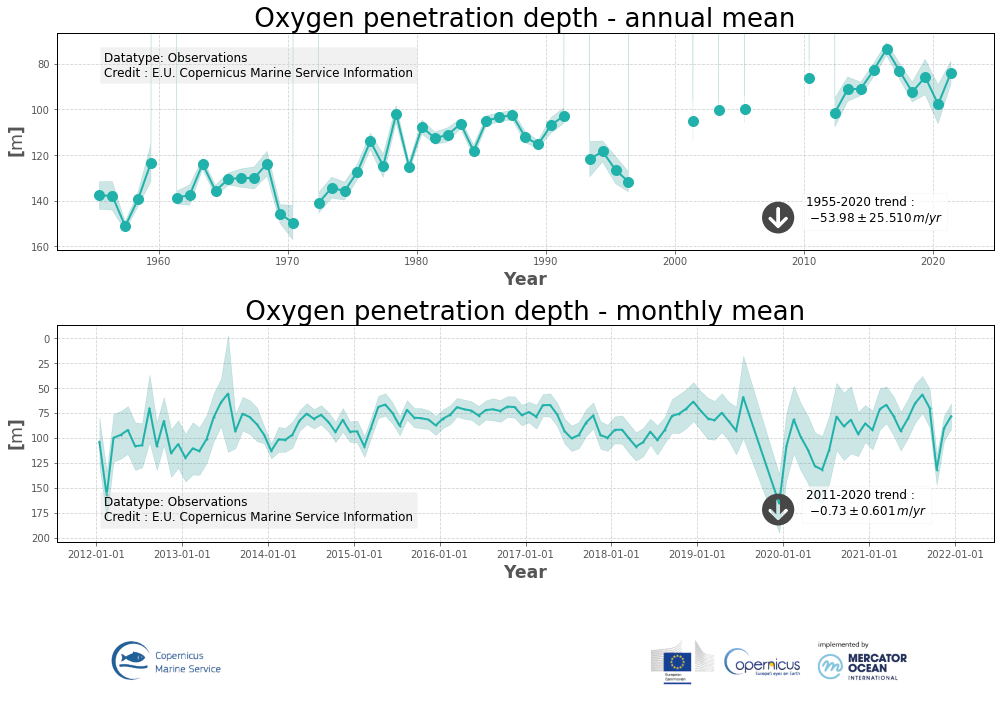

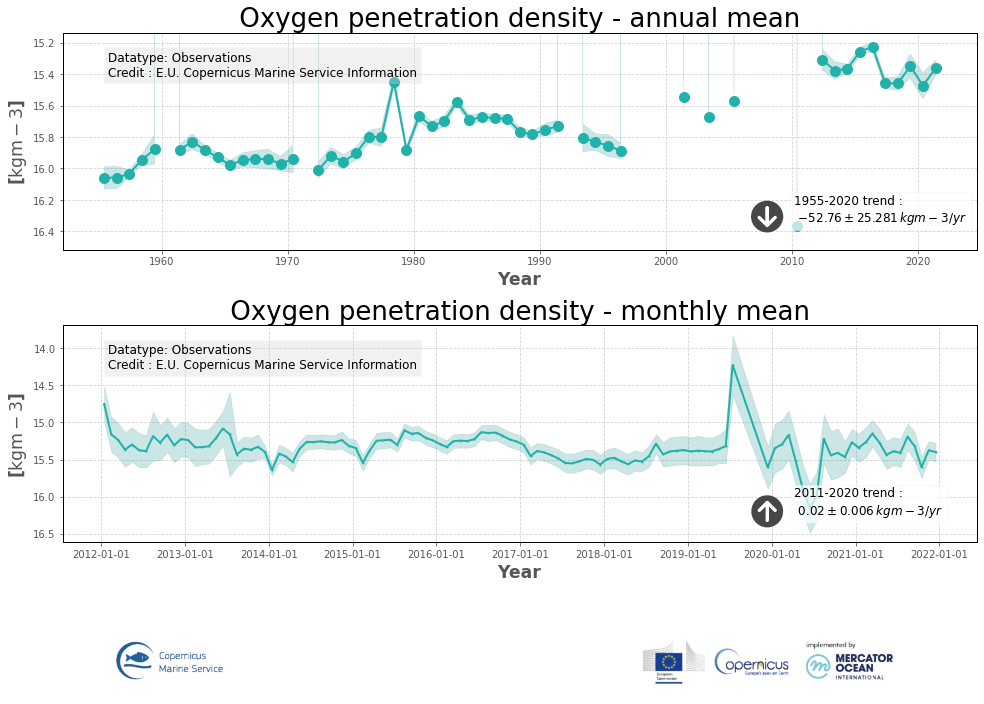

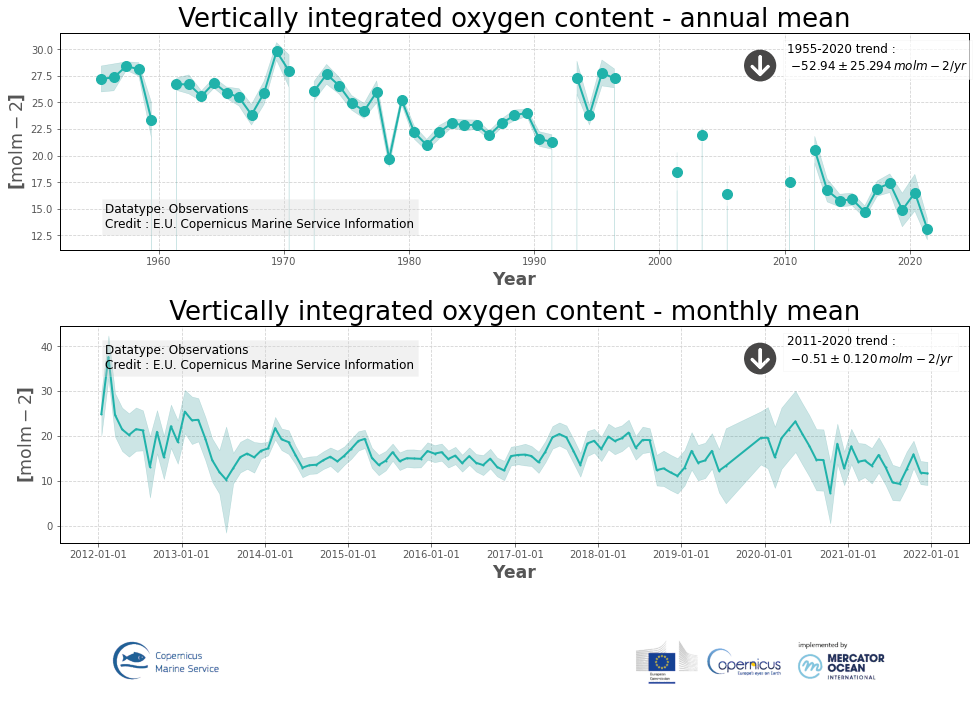

In [302]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch

import matplotlib as mpl
import matplotlib.patches as patch

#DELME import argparse
import datetime as dt
import matplotlib.dates as mdates
import sys

import pylab as pl
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

dirname=path
creationdate = prod_time

#DELME addArgo = False

#DELME VARS=['odo2','olto2','into2']

#DELME variablename={'odo2':'oxygen_penetration_density',\
#DELME              'olto2':'oxygen_penetration_depth',\
#DELME              'into2':'oxygen_inventory'}

mp='./images/'
logo             = plt.imread(mp+'LogosOMIBand-100.png') 
trend_arrow_up   = plt.imread(mp+'flash2.png')  #arrow for trend
trend_arrow_down = plt.imread(mp+'flash1.png')  #arrow for trend
addtrend = False
    
for v in vlist:
    with netCDF4.Dataset(dirname+'blksea_omi_health_oxygen_trend_'+'monthly_'+creationdate+'.nc','r') as nc:
        ens_mean = nc.variables[vdic[v]['name']+ '_mean'][:]
        ttime    = nc.variables['time'][:]
        sstd     = nc.variables[vdic[v]['name']+'_std'][:]
        units    = nc.variables[vdic[v]['name']+'_mean'].units
        longname_M = nc.variables[vdic[v]['name']+'_mean'].long_name
        
    with netCDF4.Dataset(dirname+'blksea_omi_health_oxygen_trend_'+'annual_'+creationdate+'.nc','r') as nc:
        ens_mean_Annual = nc.variables[vdic[v]['name']+ '_mean'][:]
        ttime_Annual    = nc.variables['time'][:]
        sstd_Annual     = nc.variables[vdic[v]['name']+'_std'][:]   
        longname_A      = nc.variables[vdic[v]['name']+'_mean'].long_name
           
##########
# FIGURE #
##########
    fig = plt.figure(figsize=(14,10))
    gs = gridspec.GridSpec(3, 1, height_ratios=[50,50,20])
        
    # -- Define style of the plot 
    mpl.style.use('ggplot')    

    plt.rcParams['axes.facecolor']='w'
    plt.rcParams['grid.color']='lightgrey'#   b0b0b0    # grid color
    plt.rcParams['grid.linestyle']='--'         # solid

    plt.rcParams['axes.edgecolor']='black'
    #grid.linewidth   :   0.8       # in points
    #grid.alpha       :   1.0       # transparency, between 0.0 and 1.0



    #############
    #  1st axis # -Annual
    ax1 = plt.subplot(gs[0])  
    # -- Legends & title 
    ax1.set_xlabel(' Year ', size= 'xx-large',fontweight='bold')
    ax1.set_ylabel(u'[$\mathrm{'+units+'}$]', size = 'xx-large',fontweight='bold')
    timefor1 = [dt.datetime(1950,1,1)+dt.timedelta(days=int(t)) for t in ttime_Annual]
    timefor1std = [dt.datetime(1950,1,1)+dt.timedelta(days=int(t)) for t in ttime_Annual[~np.isnan(ens_mean_Annual)]]
    locator  = mdates.AutoDateLocator()
    formator = mdates.AutoDateFormatter(locator)
    #formator = mdates.DateFormatter('%Y-%m-%d')

    ax1.xaxis_date()
    ax1.xaxis.set_major_locator(locator)
    ax1.xaxis.set_major_formatter(formator)


    # -- Ensemble mean
    ax1.plot(timefor1, ens_mean_Annual, color = 'lightseagreen',linewidth = 2, marker='o',markersize = 10)

    # -- Spread
    ax1.fill_between(timefor1std, ens_mean_Annual[~np.isnan(ens_mean_Annual)] - sstd_Annual[~np.isnan(ens_mean_Annual)], ens_mean_Annual[~np.isnan(ens_mean_Annual)] + sstd_Annual[~np.isnan(ens_mean_Annual)], alpha = 0.2, edgecolor = 'teal', facecolor = 'teal', interpolate = True)
      
    #-- Adding trend information
    fit1,cov = np.polyfit(ttime_Annual[~np.isnan(ens_mean_Annual)], ens_mean_Annual[~np.isnan(ens_mean_Annual)],1, cov=True)
    trend1 = fit1[0]*365.25
    stderroronslope = np.sqrt(np.diag(cov))[0]*365.25
    print(fit1)

    # -- Trend figure (arrow)    
    if trend1>0:
        trend_arrow = trend_arrow_up
    else:
        trend_arrow=trend_arrow_down
    
    if (v == 'VOC'):
        yfortrend   = 0.85
    else:
        yfortrend   = 0.15        
    
    imagebox = OffsetImage(trend_arrow, zoom=0.5)
    #ab = AnnotationBbox(imagebox, (mdates.date2num(timefor1[np.round(len(timefor1)/4*3)]), yfortrend), xycoords="axes fraction", bboxprops = {'facecolor':'white','alpha':0,'edgecolor':'white'})
    ab = AnnotationBbox(imagebox, (0.77, yfortrend), xycoords="axes fraction", bboxprops = {'facecolor':'white','alpha':0,'edgecolor':'white'})
    ax1.add_artist(ab)
    # -- Text 
    #ax1.text(mdates.date2num(timefor1[np.round(len(timefor1)/4*3)])+365*2,yfortrend,u'1955-2017 trend :\n $'+ "%0.2f"%(trend1) +' \pm '+ "%0.2f"%(stderroronslope) + '  ' + units +'/yr$' , bbox = {'facecolor':'white','alpha':0.7}, fontsize = 12)
    ax1.text(.8,yfortrend-0.02,u'1955-2020 trend :\n $'+ "%0.2f"%(trend1) +' \pm '+ "%0.3f"%(stderroronslope) + '\,  ' + units +'/yr$' , bbox = {'facecolor':'white','alpha':0.7}, fontsize = 12, transform=ax1.transAxes)
  
    if addtrend:
        ax1.plot(timefor1, np.polyval(fit1,ttime_Annual), color='red')
  
  
    tt = ax1.set_title(u' '+longname_A+' ', fontsize=26)
   # tt.set_position([0.5,0.95])

    #############
    #  2nd axis # - Month Mean and Instant Argo
    ax2 = plt.subplot(gs[1])  
    ax2.set_xlabel(' Year ', size= 'xx-large',fontweight='bold')
    ax2.set_ylabel(u'[$\mathrm{' + units + '}$]', size = 'xx-large',fontweight='bold')

    timefor2 = [dt.datetime(1950,1,1)+dt.timedelta(days=int(t)) for t in ttime]
    timefor2std = [dt.datetime(1950,1,1)+dt.timedelta(days=int(t)) for t in ttime[~np.isnan(ens_mean)]]
    
    locator  = mdates.AutoDateLocator()
    formator = mdates.AutoDateFormatter(locator)
    formator = mdates.DateFormatter('%Y-%m-%d')
    
    ax2.xaxis_date()
    ax2.xaxis.set_major_locator(locator)
    ax2.xaxis.set_major_formatter(formator)
    # -- Ensemble mean
    ax2.plot(timefor2, ens_mean, color = 'lightseagreen',linewidth = 2, marker='.',markersize = 2)
    # -- Spread
    ax2.fill_between(timefor2std, ens_mean[~np.isnan(ens_mean)] - sstd[~np.isnan(ens_mean)], ens_mean[~np.isnan(ens_mean)] + sstd[~np.isnan(ens_mean)], alpha = 0.2, edgecolor = 'teal', facecolor = 'teal', interpolate = True)
    # -- Adding trend information
    fit2,cov = np.polyfit(ttime[~np.isnan(ens_mean)], ens_mean[~np.isnan(ens_mean)],1, cov=True)
    trend2 = fit2[0]*365.25
    stderroronslope = np.sqrt(np.diag(cov))[0]*365.25

    print(fit2)
    # -- Trend figure (arrow)
    if trend2>0:
        trend_arrow  = trend_arrow_up
    else:
        trend_arrow=trend_arrow_down
        
    if (v == 'VOC'):
        yfortrend   = 0.85
    else:
        yfortrend   = 0.15       
        
    imagebox = OffsetImage(trend_arrow, zoom=0.5)
    ab = AnnotationBbox(imagebox,(0.77, yfortrend), xycoords="axes fraction",bboxprops = {'facecolor':'white','alpha':0,'edgecolor':'white'})
    ax2.add_artist(ab)

    # -- Text 
    ax2.text(.8,yfortrend-0.02,u'2011-2020 trend :\n $'+ "%0.2f"%(trend2) +' \pm '+ "%0.3f"%(stderroronslope) + '\,  ' + units +'/yr$' ,\
     bbox = {'facecolor':'white','alpha':0.7}, fontsize = 12,transform=ax2.transAxes)
    if addtrend:
        ax2.plot(timefor2, np.polyval(fit2,ttime), color='red')

    tt = ax2.set_title(u' '+longname_M+' ', fontsize=26)
    #tt.set_position([0.5,0.95])

    ## Add Argo

    if False:
        timeforArgo = [dt.datetime(1950,1,1)+dt.timedelta(days=int(t)) for t in ttime_daily]    
        for AA in allargo:
            ax2.plot(timeforArgo,AA, marker='.', markersize = 20, alpha = 0.1, markeredgecolor="None")
        argostrtit = '_Profs'
    else:
        argostrtit = ''

    # Custom Axis direction
    if ((v == 'Z20') or (v == 'R20')):
        ax1.invert_yaxis()
        ax2.invert_yaxis()

    #date = np.array(range(year_0,year_end+1))
       
    #ax.set_xticks(range(0,len(date),1))
    #ax2.set_xticklabels([str(l) for l in date], rotation = 30, ha = 'left',size='small') #size --> x-small,small,medium,large,...
    #ax.set_xlim( [0,len(date)] )

    # -- Credits 
    if (v == 'VOC'):
        yforcredits1 = 0.1
        yforcredits2 = 0.8
    elif (v == 'Z20'):
        yforcredits1 = 0.8
        yforcredits2 = 0.1
    elif (v == 'R20'):
        yforcredits1 = 0.8
        yforcredits2 = 0.8

    ax1.text(0.05,yforcredits1,u'Datatype: Observations \nCredit : E.U. Copernicus Marine Service Information',\
     bbox = {'facecolor':'lightgrey','alpha':0.3}, fontsize = 12, transform=ax1.transAxes)
    
    ax2.text(0.05,yforcredits2,u'Datatype: Observations \nCredit : E.U. Copernicus Marine Service Information',\
     bbox = {'facecolor':'lightgrey','alpha':0.3}, fontsize = 12, transform=ax2.transAxes)
     
    # -- Add the logos as subplot
    axlogo  = plt.subplot(gs[2])
    img     = axlogo.imshow(logo)
    axlogo.axis('off')

    # -- Graphical settings
    plt.subplots_adjust(wspace=0, hspace=-0.7)
    plt.tight_layout()
    #fig.autofmt_xdate()

    save_path = dirname
    fig_name  = 'BLKSEA_OMI_HEALTH_OXYGEN_'+vdic[v]['name']+'_trend'+argostrtit
    wanted_format = 'png'

    plt.savefig(save_path+fig_name+'.'+wanted_format,format=wanted_format, dpi=350)
    print(save_path+fig_name+'.'+wanted_format)




